In [361]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max

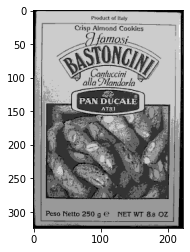

In [362]:
model_url="models/box.png"

img_model = cv2.imread(model_url)
plt.imshow(img_model)
plt.show()

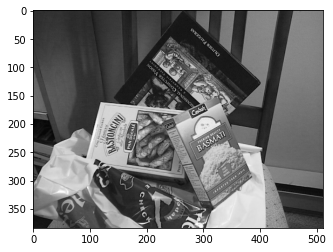

In [363]:
test_url="scenes/box_in_scene.png"

img_test = cv2.imread(test_url)
plt.imshow(img_test)
plt.show()

In [364]:
sift = cv2.xfeatures2d.SIFT_create()

kp_model = sift.detect(img_model)
kp_model, des_model = sift.compute(img_model, kp_model)

#find the reference point = baricenter
bar_x=0
bar_y=0
for i in range(0,len(kp_model)):
    bar_x=bar_x+kp_model[i].pt[0]
    bar_y=bar_y+kp_model[i].pt[1]

bar_x=(1/len(kp_model))*bar_x
bar_y=(1/len(kp_model))*bar_y

baricenter=(int(bar_x),int(bar_y))
        
        
join_vectors = []     
#compute joining vectors (r=baricenter-keypoint)
for i in range(0,len(kp_model)):
    join_vectors.append((baricenter[0]-kp_model[i].pt[0],baricenter[1]-kp_model[i].pt[1]))

In [365]:
# Baricenter position
print("baricenter:", baricenter)
# Number of keypoints
print("count kp_model:", (len(kp_model)))

baricenter: (109, 166)
count kp_model: 696


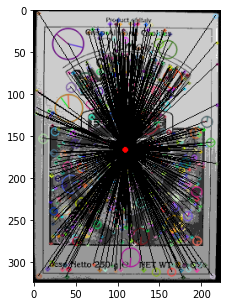

In [366]:
#visualize keypoints with drawKeypoints
#use flag DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to show scale and orientation of keypoints
img_visualization = cv2.drawKeypoints(img_model,kp_model,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#visualize joining vectors with arrowedLine
#draw joining vectors, draw an arrow line from the keypoint to the baricenter
for i in range(0,len(kp_model)):
    cv2.arrowedLine(img_visualization, (int(kp_model[i].pt[0]), int(kp_model[i].pt[1])), (baricenter[0], baricenter[1]), (0, 0, 0))


cv2.circle(img_visualization, (baricenter[0],baricenter[1]), 2, [255,0,0],2)
plt.figure(figsize=(5, 5)) 
plt.imshow(img_visualization)
plt.show()

count kp_test: 969


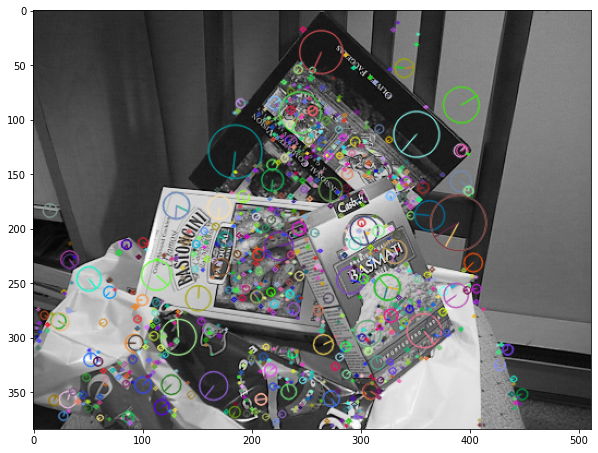

In [367]:
kp_test= sift.detect(img_test)
kp_test, des_test = sift.compute(img_test, kp_test)

# Number of keypoints
print("count kp_test:", (len(kp_test)))

img_visualization=cv2.drawKeypoints(img_test,kp_test,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10, 10)) 
plt.imshow(img_visualization)
plt.show()

In [368]:
# kdtree index algorithm
FLANN_INDEX_KDTREE = 1

#algorithm paramiter
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)

#search parameters
search_params = dict(checks = 120)

#initialize the matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

#perform the mathc: fidn the 2 closest elements for each model descriptor
matches = flann.knnMatch(des_model,des_test,k=2)


#check the distance ratio between the first and the second closest elements using 0.7 as distance ratio threshold (D.Lowe)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
print("Number of good matches:",len(good))

Number of good matches: 62


In [369]:
from math import sin, cos, radians

def rotate_point(point, angle, center_point=(0, 0)):
    """Rotates a point around center_point(origin by default)
    Angle is in degrees.
    Rotation is counter-clockwise
    """
    angle_rad = radians(angle % 360)
    # Shift the point so that center_point becomes the origin
    new_point = (point[0] - center_point[0], point[1] - center_point[1])
    new_point = (new_point[0] * cos(angle_rad) - new_point[1] * sin(angle_rad),
                 new_point[0] * sin(angle_rad) + new_point[1] * cos(angle_rad))
    # Reverse the shifting we have done
    new_point = (new_point[0] + center_point[0], new_point[1] + center_point[1])
    return new_point

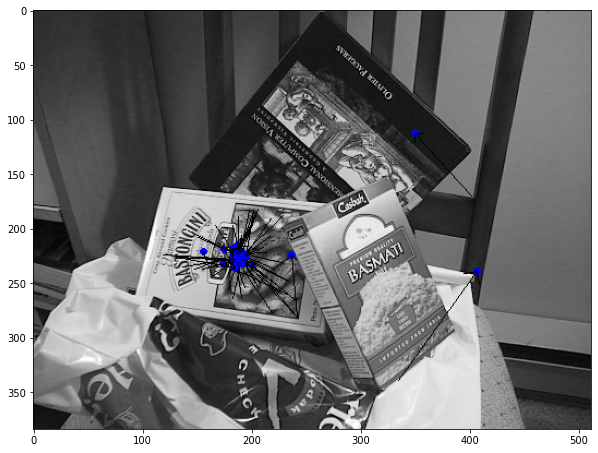

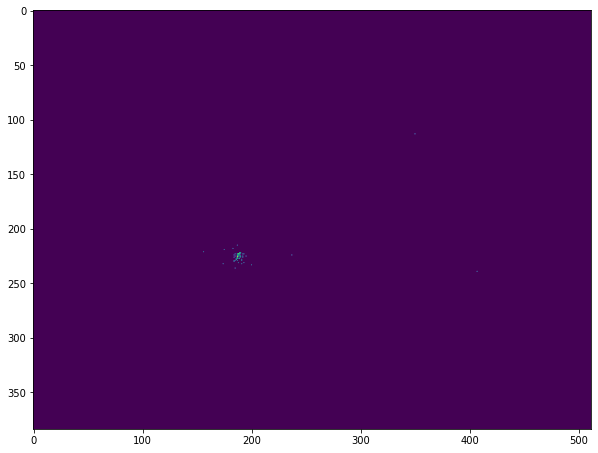

In [370]:
rf_point=[]
#define an accumulator array (AA) of the same dimension of the test image
accumulator = np.zeros((img_test.shape[0],img_test.shape[1])) 


for m in good:
    #invariance to scale 
    scale_factor=kp_model[m.queryIdx].size/kp_test[m.trainIdx].size
    
    #invariance to rotation: ratation of the joining vector based on the different orientation
    diff_orientation=kp_test[m.trainIdx].angle-kp_model[m.queryIdx].angle
    join_vectors[m.queryIdx]=rotate_point((join_vectors[m.queryIdx][0], join_vectors[m.queryIdx][1]),diff_orientation)

    #find the reference point = baricenter in the test image 
    x_rf_point=kp_test[m.trainIdx].pt[0]+join_vectors[m.queryIdx][0]/scale_factor
    y_rf_point=kp_test[m.trainIdx].pt[1]+join_vectors[m.queryIdx][1]/scale_factor
    rf_point.append((x_rf_point,y_rf_point))
        
    #accumulate votes in the accumulator
    accumulator[int(y_rf_point)][int(x_rf_point)]+=1
        
    img_visualization = cv2.circle(img_test, (int(x_rf_point),int(y_rf_point)), 2, [0,0,255],2)
    cv2.arrowedLine(img_visualization, (int(kp_test[m.trainIdx].pt[0]),  int(kp_test[m.trainIdx].pt[1])), (int(x_rf_point), int(y_rf_point)), (0, 0, 0))

plt.figure(figsize=(10, 10)) 
plt.imshow(img_visualization)
plt.show()

plt.figure(figsize=(10, 10)) 
plt.imshow(accumulator)
plt.show()
    

In [371]:
#find peaks in the accumulator
coordinates = peak_local_max(accumulator, min_distance=20, threshold_abs=2)
#print(coordinates)
rf_baricenter=coordinates[0]
print(center)

[223 188]


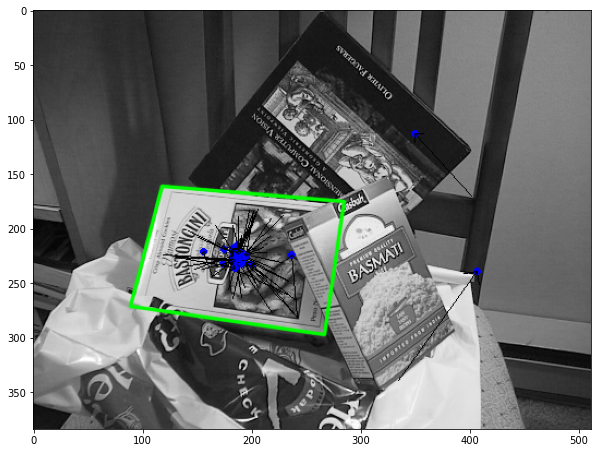

In [372]:
src_pts=[]
dst_pts=[]
i=0

#consider points in a 5x5 box around the rf_baricenter to estimate a homography
for m in good:
    if(rf_baricenter[0]-5<rf_point[i][1]<rf_baricenter[0]+5 and 
        rf_baricenter[1]-5<rf_point[i][0]<rf_baricenter[1]+5):
        src_pts.append(kp_model[m.queryIdx].pt)
        dst_pts.append(kp_test[m.trainIdx].pt)
    i+=1

#RANSAC to estimate a robust homography
M, mask = cv2.findHomography(np.asarray(src_pts), np.asarray(dst_pts), cv2.RANSAC, 5.0)

# Corners of the query image
h= img_model.shape[0]
w= img_model.shape[1]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

#project model image corners into the test image
dst = cv2.perspectiveTransform(pts,M)

#draw the bounding box
img_output=cv2.polylines(img_test,[np.int32(dst)],True,(0,255,0),2, cv2.LINE_AA) 

plt.figure(figsize=(10,10)) 
plt.imshow(img_output)
plt.show()   